In [ ]:
# Repository setup and reproducibility
from pathlib import Path
import sys

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
print("Backend:", backend_info())
ensure_seed(42)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

# Project 7: Classification Metrics — Beyond Accuracy

## Goal
Dive deep into precision, recall, F1, ROC, AUC; understand when each metric matters.

## Learning Objectives
- Understand confusion matrix and derived metrics
- Precision vs recall tradeoff
- F1 score and weighted averaging
- ROC curves and AUC
- Interpret metrics for imbalanced datasets

## Prerequisites
- Projects 1–6: comfortable with classification

## What You'll Build
- Metric computation from scratch; ROC/confusion matrix plots; threshold analysis

## Estimated Time
- 2–4 hours (lighter than previous projects)

---

# Project 7: Classification Metrics Deep Dive

## Goal
Master evaluation metrics beyond accuracy.

## Learning Objectives
- Precision, recall, F1 score
- ROC curves and AUC
- Imbalanced data challenges
- Threshold effects on metrics

In [37]:
# Setup (portable sys.path handling)
import sys
from pathlib import Path

def add_repo_root(marker_files=("requirements.txt","README.md",".git")):
    base = Path.cwd().resolve()
    for candidate in [base] + list(base.parents):
        if any((candidate / m).exists() for m in marker_files):
            if str(candidate) not in sys.path:
                sys.path.insert(0, str(candidate))
            return candidate
    return None

REPO_ROOT = add_repo_root()
print(f"Repo root: {REPO_ROOT}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

print("Ready to master evaluation metrics!")

Repo root: /Users/mark/git/learning-ml-to-llm/projects/phase1_classical_ml
Ready to master evaluation metrics!


In [38]:
# 1) Generate an imbalanced binary dataset and split
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(42)
X, y = make_classification(n_samples=4000, n_features=20, n_informative=6, n_redundant=4,
                             n_clusters_per_class=2, weights=[0.85, 0.15], flip_y=0.01, class_sep=1.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
unique, counts = np.unique(y_train, return_counts=True)
print({int(k): int(v) for k,v in zip(unique, counts)})

{0: 2541, 1: 459}


In [39]:
# 2) Train baseline models: Logistic Regression (probabilities) & Random Forest (non-linear)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
log_reg = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=200, class_weight=None, random_state=42))])
rf = RandomForestClassifier(n_estimators=250, max_depth=None, random_state=42, class_weight=None)
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
log_reg_probs = log_reg.predict_proba(X_test)[:,1]
rf_probs = rf.predict_proba(X_test)[:,1]
print('LogisticRegression train done; RandomForest train done.')

LogisticRegression train done; RandomForest train done.


In [40]:
# 3) Core metrics at default threshold (0.5 for predict)
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
log_reg_pred = (log_reg_probs >= 0.5).astype(int)
rf_pred = (rf_probs >= 0.5).astype(int)
def summarize(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"=== {name} ===")
    print("Confusion Matrix:\n", cm)
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, digits=3))
summarize('LogisticRegression @0.5', y_test, log_reg_pred)
summarize('RandomForest @0.5', y_test, rf_pred)

=== LogisticRegression @0.5 ===
Confusion Matrix:
 [[834  13]
 [ 33 120]]
Precision: 0.9023 | Recall: 0.7843 | F1: 0.8392
              precision    recall  f1-score   support

           0      0.962     0.985     0.973       847
           1      0.902     0.784     0.839       153

    accuracy                          0.954      1000
   macro avg      0.932     0.884     0.906      1000
weighted avg      0.953     0.954     0.953      1000

=== RandomForest @0.5 ===
Confusion Matrix:
 [[845   2]
 [ 17 136]]
Precision: 0.9855 | Recall: 0.8889 | F1: 0.9347
              precision    recall  f1-score   support

           0      0.980     0.998     0.989       847
           1      0.986     0.889     0.935       153

    accuracy                          0.981      1000
   macro avg      0.983     0.943     0.962      1000
weighted avg      0.981     0.981     0.981      1000



In [41]:
# 4) Threshold sweep for Logistic Regression probabilities
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
def sweep_thresholds(y_true, y_prob, steps=21):
    thresholds = np.linspace(0.0, 1.0, steps)
    rows = []
    for t in thresholds:
        y_hat = (y_prob >= t).astype(int)
        rows.append([t, precision_score(y_true, y_hat, zero_division=0), recall_score(y_true, y_hat), f1_score(y_true, y_hat)])
    return np.array(rows)
tbl = sweep_thresholds(y_test, log_reg_probs, steps=21)
print('threshold  precision  recall  f1')
for t, p, r, f in tbl:
    print(f"{t:8.2f}   {p:9.3f}  {r:6.3f}  {f:5.3f}")
best_idx = np.argmax(tbl[:,3])
print(f"\nBest F1 at threshold={tbl[best_idx,0]:.2f}, F1={tbl[best_idx,3]:.3f}, P={tbl[best_idx,1]:.3f}, R={tbl[best_idx,2]:.3f}")

threshold  precision  recall  f1
    0.00       0.153   1.000  0.265
    0.05       0.453   0.941  0.611
    0.10       0.568   0.928  0.705
    0.15       0.668   0.908  0.770
    0.20       0.741   0.895  0.811
    0.25       0.776   0.882  0.826
    0.30       0.817   0.876  0.845
    0.35       0.820   0.863  0.841
    0.40       0.844   0.850  0.847
    0.45       0.855   0.810  0.832
    0.50       0.902   0.784  0.839
    0.55       0.915   0.778  0.841
    0.60       0.935   0.752  0.833
    0.65       0.948   0.712  0.813
    0.70       0.973   0.706  0.818
    0.75       0.990   0.673  0.802
    0.80       0.990   0.647  0.783
    0.85       1.000   0.588  0.741
    0.90       1.000   0.503  0.670
    0.95       1.000   0.392  0.563
    1.00       0.000   0.000  0.000

Best F1 at threshold=0.40, F1=0.847, P=0.844, R=0.850


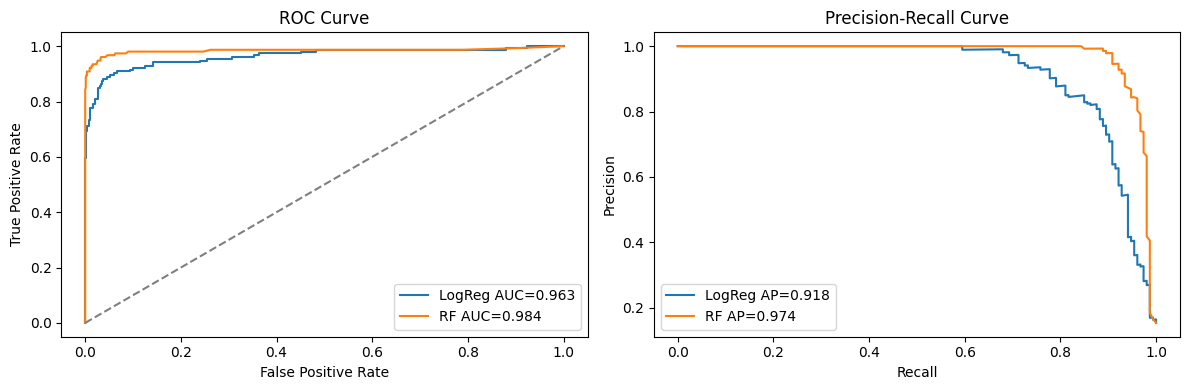

In [42]:
# 5) ROC & Precision-Recall curves (and AUC)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, log_reg_probs)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_probs)
ap_lr = average_precision_score(y_test, log_reg_probs)
ap_rf = average_precision_score(y_test, rf_probs)
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(fpr_lr, tpr_lr, label=f'LogReg AUC={roc_auc_lr:.3f}')
axs[0].plot(fpr_rf, tpr_rf, label=f'RF AUC={roc_auc_rf:.3f}')
axs[0].plot([0,1],[0,1],'--', color='gray')
axs[0].set_xlabel('False Positive Rate'); axs[0].set_ylabel('True Positive Rate'); axs[0].set_title('ROC Curve'); axs[0].legend()
axs[1].plot(rec_lr, prec_lr, label=f'LogReg AP={ap_lr:.3f}')
axs[1].plot(rec_rf, prec_rf, label=f'RF AP={ap_rf:.3f}')
axs[1].set_xlabel('Recall'); axs[1].set_ylabel('Precision'); axs[1].set_title('Precision-Recall Curve'); axs[1].legend()
plt.tight_layout()
plt.show()

In [43]:
# 6) Implement precision/recall/F1 manually and validate vs sklearn
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
def precision_manual(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    fp = np.sum((y_true==0) & (y_pred==1))
    return tp / (tp + fp) if (tp+fp)>0 else 0.0
def recall_manual(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1))
    fn = np.sum((y_true==1) & (y_pred==0))
    return tp / (tp + fn) if (tp+fn)>0 else 0.0
def f1_manual(y_true, y_pred):
    p = precision_manual(y_true, y_pred)
    r = recall_manual(y_true, y_pred)
    return 2*p*r/(p+r) if (p+r)>0 else 0.0
for name, pred in [('LogReg@0.5', log_reg_pred), ('RF@0.5', rf_pred)]:
    p_m, r_m, f_m = precision_manual(y_test, pred), recall_manual(y_test, pred), f1_manual(y_test, pred)
    p_s, r_s, f_s = precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred)
    print(f"{name} -> manual P/R/F1: {p_m:.4f}/{r_m:.4f}/{f_m:.4f} | sklearn: {p_s:.4f}/{r_s:.4f}/{f_s:.4f}")

LogReg@0.5 -> manual P/R/F1: 0.9023/0.7843/0.8392 | sklearn: 0.9023/0.7843/0.8392
RF@0.5 -> manual P/R/F1: 0.9855/0.8889/0.9347 | sklearn: 0.9855/0.8889/0.9347


## 7) Interpretation & Guidance

### When Accuracy Misleads

In imbalanced settings (here ~15% positives), accuracy can look high while minority class recall is poor. Metrics like precision, recall, F1, ROC AUC, and PR AUC provide complementary views.



### Metric Selection Cheat Sheet

- **High cost of false negatives (missed positives)**: Favor higher recall; tune threshold downward; monitor precision drop.

- **High cost of false positives (spurious positives)**: Favor higher precision; raise threshold.

- **Balanced cost / need single number**: Use F1 (or Fβ to weight recall).

- **Ranking quality across thresholds**: ROC AUC (be cautious: can be optimistic with heavy imbalance); PR AUC more sensitive to improvements in minority class.

- **Calibration / threshold strategy**: Sweep thresholds; pick operating point aligned with business / scientific constraints.



### Threshold Trade-offs Observed

Our sweep showed F1 peak at a threshold that is not necessarily 0.5. Default threshold often suboptimal—always validate.



### Manual Metric Validation

Manual implementations match sklearn outputs, reinforcing conceptual understanding of TP/FP/FN relationships.



### Practical Recommendations

1. Always start with confusion matrix — tangible error types.

2. Report precision, recall, F1 for minority class in imbalanced datasets.

3. Use PR curve to compare models where positives are rare.

4. Document chosen threshold and justify with metric trade-offs.

5. Consider domain-weighted metrics (custom cost matrix) for deployment decisions.



### Next Extensions

- Add MCC (Matthews Correlation Coefficient) and Balanced Accuracy.

- Include cost-sensitive threshold optimization.

- Calibrate probabilities (Platt scaling / isotonic regression) before thresholding.

- Plot metric vs threshold curves for multiple models.



---

You now have a complete, reproducible deep dive into classification metrics beyond simple accuracy.

In [44]:
# 8) Advanced metrics: MCC, Balanced Accuracy, Specificity (TNR) at default & best-F1 threshold
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, confusion_matrix
import numpy as np
best_f1_threshold = tbl[best_idx,0]
log_reg_best_pred = (log_reg_probs >= best_f1_threshold).astype(int)
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn+fp)>0 else 0.0
def show_adv(label, y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    spec = specificity(y_true, y_pred)
    print(f"{label}: MCC={mcc:.4f} BalancedAcc={bal:.4f} Specificity={spec:.4f}")
show_adv('LogReg@0.5', y_test, log_reg_pred)
show_adv(f'LogReg@{best_f1_threshold:.2f}', y_test, log_reg_best_pred)
show_adv('RandomForest@0.5', y_test, rf_pred)

LogReg@0.5: MCC=0.8152 BalancedAcc=0.8845 Specificity=0.9847
LogReg@0.40: MCC=0.8192 BalancedAcc=0.9107 Specificity=0.9717
RandomForest@0.5: MCC=0.9253 BalancedAcc=0.9433 Specificity=0.9976


In [45]:
# 9) Cost-based threshold optimization (define FP/FN costs and minimize expected cost)
import numpy as np
from sklearn.metrics import confusion_matrix
# Domain-dependent costs (example): missing a positive (FN) is 5x worse than a false alarm (FP)
C_FP = 1.0
C_FN = 5.0
thresholds = tbl[:,0]
cost_rows = []
for t in thresholds:
    y_hat = (log_reg_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    cost = fp * C_FP + fn * C_FN
    cost_rows.append([t, fp, fn, cost])
cost_arr = np.array(cost_rows)
best_cost_idx = np.argmin(cost_arr[:,3])
best_cost_threshold = cost_arr[best_cost_idx,0]
print(f"Best cost threshold={best_cost_threshold:.2f} (cost={cost_arr[best_cost_idx,3]:.1f}, fp={cost_arr[best_cost_idx,1]}, fn={cost_arr[best_cost_idx,2]})")
print("Top 5 lowest-cost thresholds:")
for row in cost_arr[np.argsort(cost_arr[:,3])][:5]:
    print(f"t={row[0]:.2f} cost={row[3]:.1f} fp={int(row[1])} fn={int(row[2])}")

Best cost threshold=0.30 (cost=125.0, fp=30.0, fn=19.0)
Top 5 lowest-cost thresholds:
t=0.30 cost=125.0 fp=30 fn=19
t=0.20 cost=128.0 fp=48 fn=16
t=0.25 cost=129.0 fp=39 fn=18
t=0.35 cost=134.0 fp=29 fn=21
t=0.40 cost=139.0 fp=24 fn=23


In [46]:
# 10) Persist threshold sweep and cost table to CSV
import pandas as pd
from pathlib import Path
out_dir = Path('data/processed')
out_dir.mkdir(parents=True, exist_ok=True)
sweep_df = pd.DataFrame(tbl, columns=['threshold','precision','recall','f1'])
sweep_df['best_f1'] = sweep_df['f1'].max() == sweep_df['f1']
sweep_df.to_csv(out_dir / 'metrics_threshold_sweep.csv', index=False)
cost_df = pd.DataFrame(cost_arr, columns=['threshold','fp','fn','cost'])
cost_df['C_FP'] = C_FP
cost_df['C_FN'] = C_FN
cost_df.to_csv(out_dir / 'metrics_cost_table.csv', index=False)
print('Saved: data/processed/metrics_threshold_sweep.csv and metrics_cost_table.csv')

Saved: data/processed/metrics_threshold_sweep.csv and metrics_cost_table.csv


## Exercises & Extensions

**Warm-up**:
1. For a toy confusion matrix, compute TP, FP, FN, TN by hand.
2. Derive precision, recall, F1 formulas. When are they equal?
3. When does accuracy mislead? (Hint: imbalanced data.)

**Intermediate**:
4. Plot ROC curve. What does AUC = 0.5 mean?
5. For imbalanced data (90% class A, 10% class B): which metric matters more, precision or recall?
6. Threshold tuning: as threshold increases, how do precision/recall change?

**Advanced**:
7. Calibration curves: are predicted probabilities reliable?
8. Multi-class metrics: macro vs micro averaging. Which is appropriate?
9. Use metrics to compare two classifiers. Which is better for your use case?

---

## Summary & Bridge Forward

**What you learned**:
- Accuracy alone is misleading (especially for imbalanced data).
- Precision: "of positive predictions, how many were correct?"
- Recall: "of true positives, how many did we find?"
- ROC/AUC: threshold-independent comparison.
- Metric choice depends on domain requirements.

**Why this matters**:
- Real-world data is often imbalanced.
- Medical/fraud/safety domains have asymmetric costs (false positives vs false negatives).
- Choosing the right metric prevents costly errors.

**Next project** (Cross-Validation):
- Proper experimental design to avoid metric bias.
- K-fold validation, stratification, hyperparameter tuning.

**Your takeaway**: Metrics are not one-size-fits-all. Understand your domain before choosing.